# Bitcoin Time Series Prediction with LSTM

#### Import necessary library needed for the model training

In [9]:
from math import sqrt
from matplotlib import pyplot
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
from PIL import Image
py.init_notebook_mode(connected=True)
%matplotlib inline
pd.options.display.expand_frame_repr = False

#### Show LSTM-model

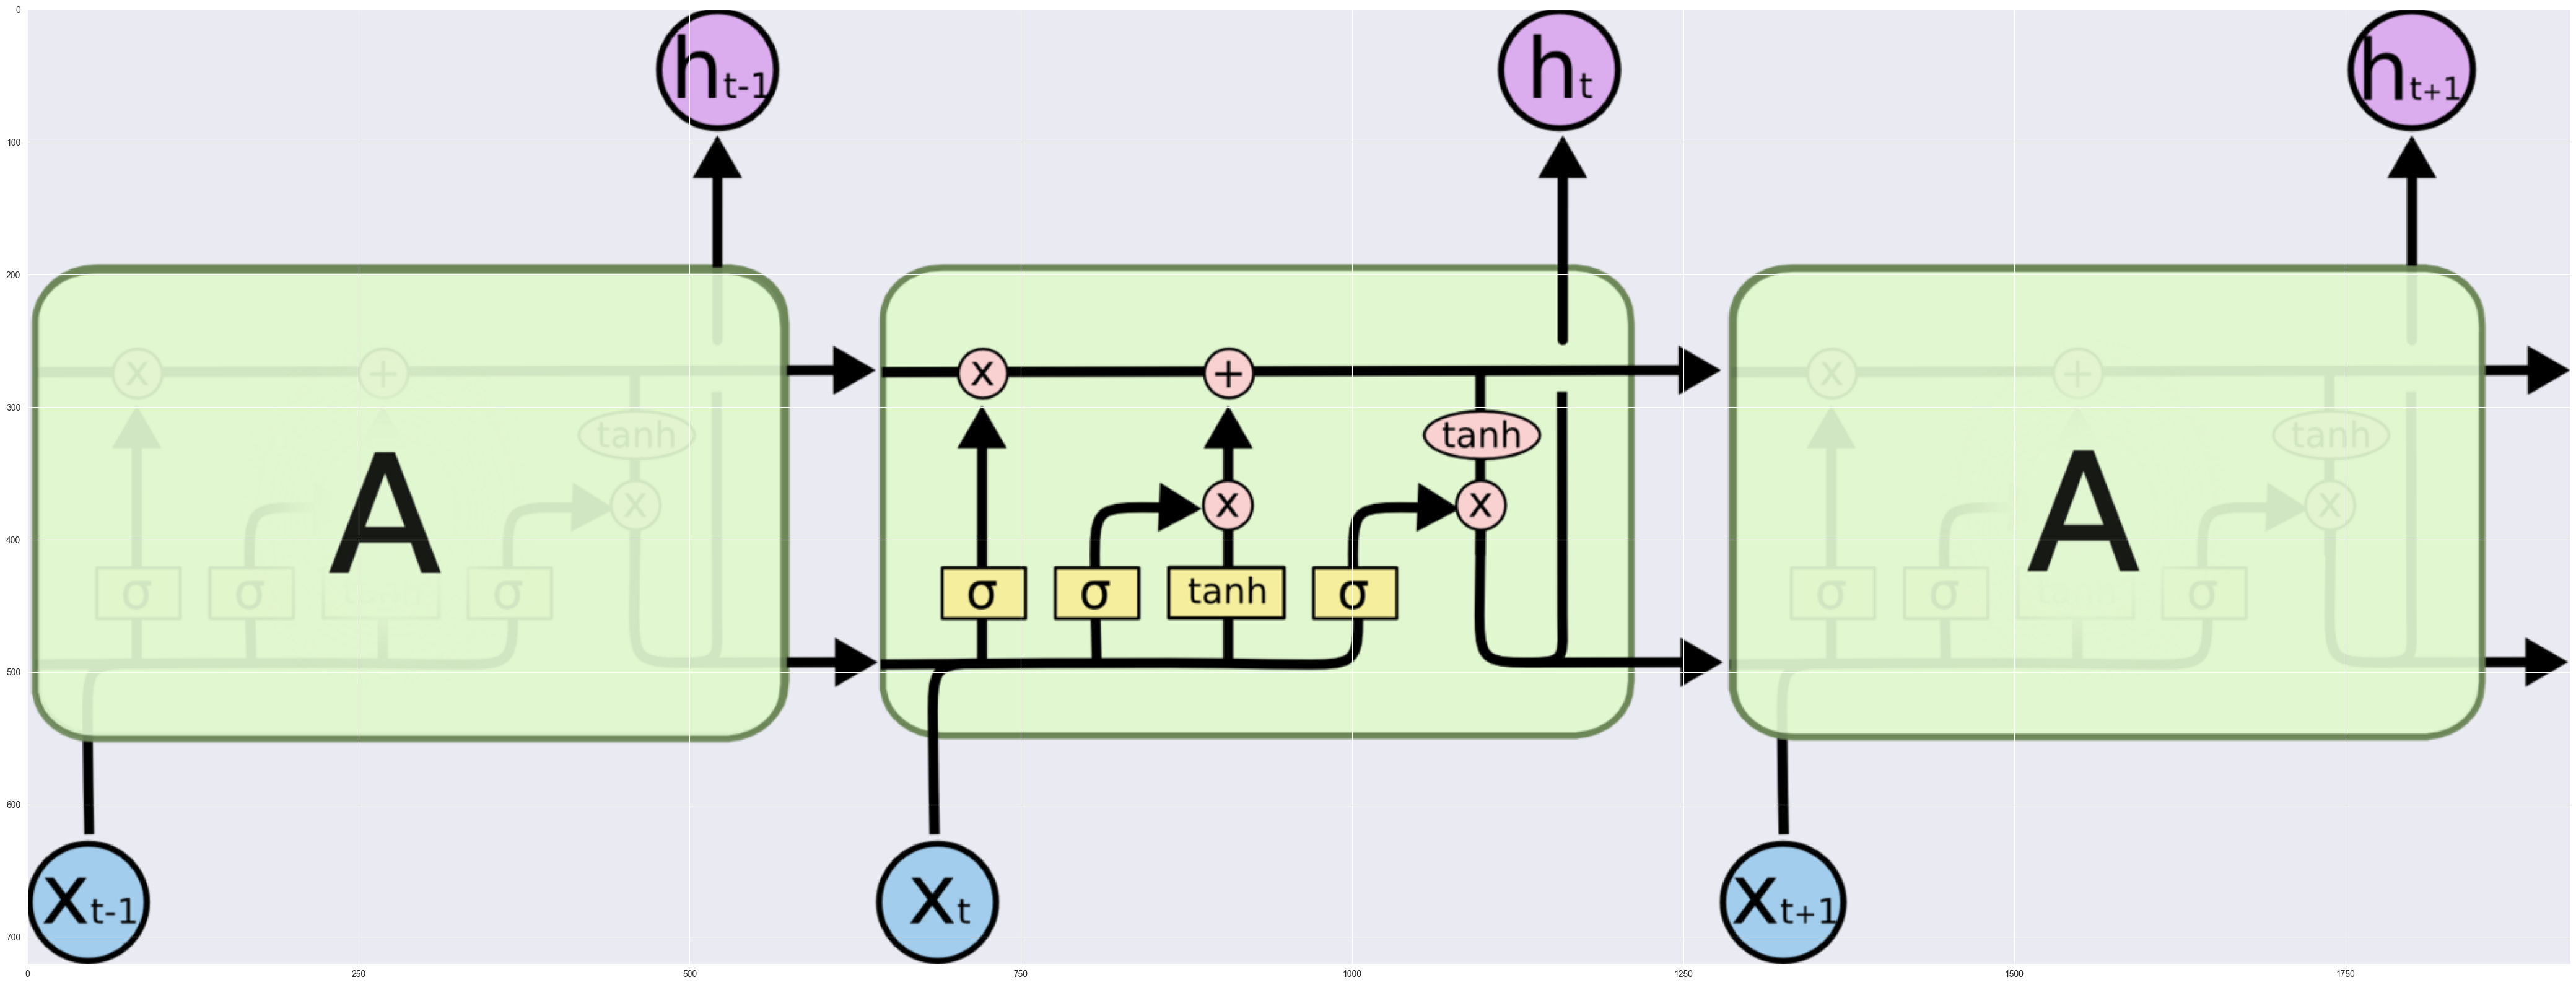

In [10]:
img = Image.open('lstm.png')
pyplot.figure(figsize=(img.width/72*2, img.height/72*2))
pyplot.imshow(img)
pyplot.show()

#### Read data set

In [11]:
data = pd.read_csv(filepath_or_buffer="bitcoin.csv", low_memory=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        2001 non-null   int64  
 1   high        2001 non-null   float64
 2   low         2001 non-null   float64
 3   open        2001 non-null   float64
 4   volume      2001 non-null   float64
 5   close       2001 non-null   float64
 6   macd        2001 non-null   float64
 7   macds       2001 non-null   float64
 8   macdh       2001 non-null   float64
 9   rs_5        2000 non-null   float64
 10  rsi_5       2000 non-null   float64
 11  stochrsi_5  1999 non-null   float64
 12  wt1         2000 non-null   float64
 13  wt2         2000 non-null   float64
 14  change      2001 non-null   float64
 15  vr          2001 non-null   float64
 16  wr          2001 non-null   float64
 17  trix        2001 non-null   float64
 18  tema        2001 non-null   float64
 19  cci         2000 non-null  

In [12]:
data = data.sort_values(by='time')
data.head()

,time,high,low,open,volume,close,macd,macds,macdh,rs_5,...,trix,tema,cci,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj
0,1677844800,22373.95,22335.29,22353.64,43321603.88,22354.46,0.000000,0.000000,0.000000,NaN,...,0.000000,22354.460000,NaN,49.586136,49.862045,49.862045,49.954015,49.954015,49.678105,49.678105
1,1677848400,22422.63,22216.58,22354.46,85377318.81,22412.67,1.305994,0.725552,0.580442,inf,...,0.041384,22408.944560,-66.666667,95.166222,64.963437,64.963437,54.957156,54.957156,84.976000,84.976000
2,1677852000,22473.49,22372.88,22412.67,66087341.01,22389.82,0.955518,0.819800,0.135718,2.037987,...,0.024523,22396.567779,100.000000,67.432175,65.786350,65.786350,58.566887,58.566887,80.225275,80.225275
3,1677855600,22415.64,22286.76,22389.82,71181941.49,22340.74,-0.999317,0.203568,-1.202885,0.553064,...,0.009848,22352.767441,-53.917735,48.328208,59.966969,59.966969,59.033581,59.033581,61.833746,61.833746
4,1677859200,22384.60,22329.66,22340.74,30127063.38,22381.94,-0.401065,0.023704,-0.424768,1.317613,...,0.005489,22370.572313,-2.442595,64.364953,61.432964,61.432964,59.833375,59.833375,64.632141,64.632141


#### Plot line graph base on `Weighted Price`

In [13]:
# Заполняем NaN предыдущим значением
data = data.drop(data.index[:10])

columns = data.columns
for column in columns:
    data[column].replace(0, np.nan, inplace=True)
    data[column].fillna(method='ffill', inplace=True)

btc_trace = go.Scatter(x=data['time'], y=data['open'], name= 'Price')
py.iplot([btc_trace])

#### Function to convert series to supervised learning

In [14]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### Use MinMaxScaler to normalize `Weighted Price` to range from 0 to 1

In [15]:
columns = ['open', 'close', 'high', 'low', 'volume', 'macd', 'macds',
           'macdh', 'rs_5', 'rsi_5', 'stochrsi_5', 'wt1', 'wt2', 'change', 'vr',
           'wr', 'trix', 'tema', 'cci', 'rsv_9', 'kdjk_9', 'kdjk', 'kdjd_9',
           'kdjd', 'kdjj_9', 'kdjj']

reframed = pd.DataFrame(columns=columns)

scaler_mas = []

for column in columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    item = data[column].values.reshape(-1,1)
    item = item.astype('float32')
    item = scaler.fit_transform(item)
    reframed[column] = item.reshape(-1)
    scaler_mas.append(scaler)

print(reframed.tail())
values = reframed.values

          open     close      high       low    volume      macd     macds     macdh      rs_5     rsi_5  ...      trix      tema       cci     rsv_9    kdjk_9      kdjk    kdjd_9      kdjd    kdjj_9      kdjj
1986  0.581409  0.586109  0.580984  0.591122  0.073777  0.337920  0.307559  0.581092  0.028640  0.485404  ...  0.377544  0.584232  0.481830  0.440638  0.523360  0.523360  0.650972  0.650972  0.391753  0.391753
1987  0.586109  0.592144  0.587528  0.595127  0.065630  0.345588  0.314769  0.584798  0.043658  0.593575  ...  0.383778  0.588430  0.572689  0.583724  0.542985  0.542985  0.617055  0.617055  0.470883  0.470883
1988  0.592144  0.594740  0.588854  0.601821  0.058732  0.353994  0.322378  0.589781  0.051734  0.635751  ...  0.390322  0.592182  0.607497  0.683056  0.594824  0.594824  0.613233  0.613233  0.576959  0.576959
1989  0.594740  0.603472  0.606056  0.605167  0.113452  0.367362  0.331394  0.607333  0.085685  0.749884  ...  0.398318  0.599924  0.697929  0.706993  0.638723 

#### Split 70% of data for training and 30% for testing

In [16]:
train_size = int(len(values) * 0.7)
train, test = values[0:train_size], values[train_size::]

#### Create function for creating dataset with look back

In [17]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(look_back, len(dataset)):
        dataX.append(dataset[i-look_back:i])
        dataY.append([dataset[i][0]])
    return np.array(dataX), np.array(dataY)


#### Generate dataset for trainX, trainY, testX, testY

In [18]:
lb = 1
trainX, trainY = create_dataset(train, lb)
testX, testY = create_dataset(test, lb)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1392, 1, 26) (1392, 1) (597, 1, 26) (597, 1)


#### Running the LSTM model with 300 epochs

In [19]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, verbose=0, shuffle=False, validation_data=(testX, testY))

#### Plot line graph to show amount loss according the epoch

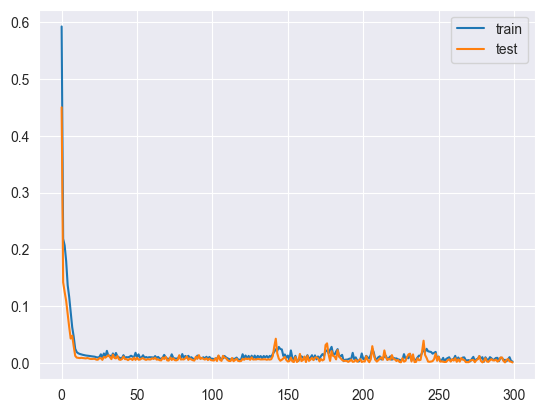

In [20]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### Make prediction using testX and plotting line graph against testY

19/19 [==============================] - 0s 2ms/step
597


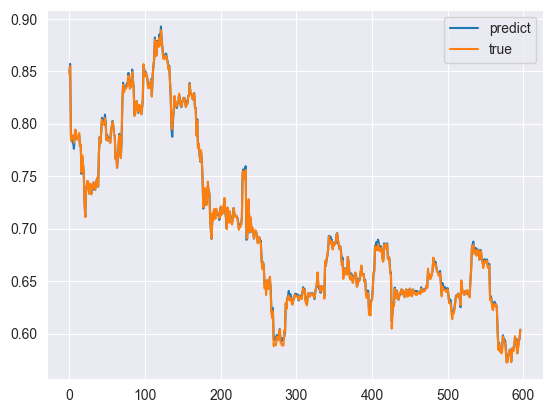

In [21]:
yhat = model.predict(testX)
print(len(yhat))
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

#### Scaler Inverse Y back to normal value

In [22]:
testY_inverse = scaler_mas[0].inverse_transform(testY)
yhat_inverse = scaler_mas[0].inverse_transform(yhat)

#### RMSE

In [23]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: {}'.format(rmse))

Test RMSE: 21.70213857212039


#### Convert X to dates

In [24]:
predictDates = data.tail(len(testX)).time

#### Plot line graph with Y as USD

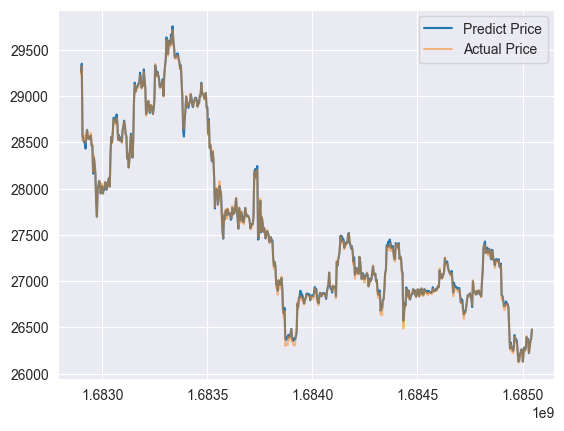

In [25]:
pyplot.plot(predictDates, yhat_inverse, label='Predict Price')
pyplot.plot(predictDates, testY_inverse, label='Actual Price', alpha=0.5)
pyplot.legend()
pyplot.show()

#### Reshape testY and yhat for plotly

In [26]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

#### Plot predicted and actual line graph with X=dates, Y=USD

In [27]:
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
py.iplot([predict_chart, actual_chart])

### Using additional features for model training

#### Find corrleration in features to `Weighted Price`

<Axes: >

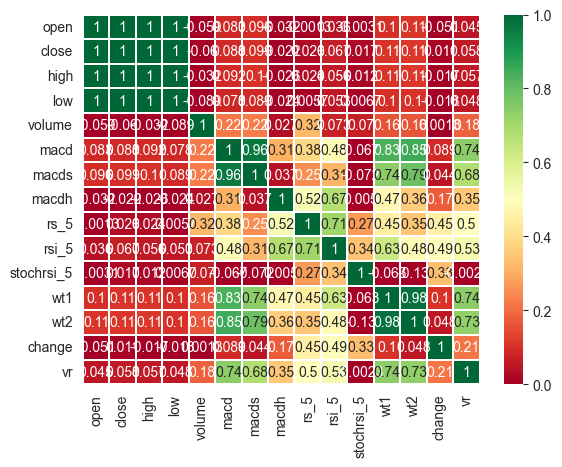

In [28]:
sns.heatmap(data[columns[:15]].corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

Observation: `Volume` is corrlerated to `Weighted Price`.
`Open`, `High`, `Low`, `Close` are directly related to `Weighted Price`